In [59]:
%load_ext autoreload
%autoreload 2
import sys
import os
project_root = os.path.abspath("/Users/joschua/repos/harris_lab/hypnose/hypnose-analysis")
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import numpy as np 
import utils
from utils import *
from pathlib import Path
import harp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
from functools import reduce
from src.processing import detect_settings
import src.processing.detect_stage as detect_stage_module

%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# Multi Date or SubjID Analysis. Can analyze all Sessions for given SubjID (run on subjid only), all SubjIDs for a date (run on date only), or specific SubjID(s) and Date(s) (run on lists of each)
# To analyze all subjids for a date, or vice versa, set the other argument to None

subjids = []
dates = [20250909]

multi_run_results = batch_analyze_sessions(subjids=None, dates=dates, save=True, verbose=False, print_summary=True)

[batch_analyze_sessions] WARNING: Date 20250909 not found for subject 15.
[batch_analyze_sessions] WARNING: Date 20250909 not found for subject 16.
[batch_analyze_sessions] WARNING: Date 20250909 not found for subject 17.
[batch_analyze_sessions] WARNING: Date 20250909 not found for subject 18.
[batch_analyze_sessions] WARNING: Date 20250909 not found for subject 19.

[batch_analyze_sessions] Analyzing subject 20, date 20250909...
Detected stage: QuintupleProbeA_Stage2_Location0
Hidden rule index: 0
Detected stage: QuintupleA_Stage5B
No hidden rule index found
Detected stage: QuintupleA_Stage5B
No hidden rule index found

SUMMARY: TRIAL CLASSIFICATION AND POKE TIME ANALYSIS FOR SUBJECT [20] DATE [20250909]

Sample offset time: 200.0 ms
Minimum sampling time: 200.0 ms
Response time window: 2 s

TRIAL CLASSIFICATIONs:
Hidden Rule Location: Position 1 (index 0)

Hidden Rule Odors: OdorA, OdorB

Total attempts: 1100
-- Non-initiated sequences (total): 776 (70.5%)
    -- Position 1 attempts

In [60]:
res = analyze_session_multi_run_by_id_date(25, 20250917, verbose=False, print_summary=True, save=True)

Detected stage: DoublesA_Stage5A
No hidden rule index found

SUMMARY: TRIAL CLASSIFICATION AND POKE TIME ANALYSIS FOR SUBJECT [25] DATE [20250917]

Sample offset time: 200.0 ms
Minimum sampling time: 200.0 ms
Response time window: 99999 s

TRIAL CLASSIFICATIONs:
Hidden Rule Location: Position None (index None)

Hidden Rule Odors: None

Total attempts: 0
-- Non-initiated sequences (total): 0 (0.0%)
    -- Position 1 attempts within trials 0 (0.0%)
    -- Baseline non-initiated sequences 0 (0.0%)
-- Initiated sequences (trials]): 0 (0.0%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 0 ( 0.0%)
   -- Hidden Rule trials (HR): 0 (0.0%)
   -- Hidden Rule Missed (HR_missed): 0 (0.0%)
-- Aborted sequences: 0 ( 0.0%)
   -- Aborted Hidden Rule trials (HR): 0 (0.0%)

REWARDED TRIALS BREAKDOWN:
-- Rewarded: 0 (0.0%)
-- Unrewarded: 0 (0.0%)
-- Reward Timeout: 0 (0.0%)

POKE TIME RANGES BY POSITION:
----------------------------------------

VALVE TIME RANGES BY POSITION:
---------------------

In [6]:
# Loading experiments --> just define the SUBJID and DATE
root = load_experiment(26, 20250908, index=0) #can add index for multiple experiments; index=0 as default
stage = detect_stage_module.detect_stage(root)

Using subject directory: /Volumes/harris/hypnose/rawdata/sub-026_id-077
Loaded experiment: /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-121_date-20250908/behav/2025-09-08T12-55-53
Detected stage: QuintupleProbeA_Stage2_Location0
Hidden rule index: 0


In [7]:
data = load_all_streams(root)

Loading data streams from: /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-121_date-20250908/behav/2025-09-08T12-55-53
Loaded heartbeat data
Calculated real-time offset: 44411 days, 11:09:22
Created timestamp interpolation mapping
Loaded digital_input_data
Loaded output_set
Loaded output_clear
Loaded olfactometer_valves_0
Loaded olfactometer_valves_1
Loaded olfactometer_end_0
Loaded analog_data
Loaded flow_meter
Loaded video_data
Loaded pulse_supply_1
Loaded pulse_supply_2
Created odour_led

Applying time corrections to all data streams...
Applied correction to digital_input_data
Applied correction to output_set
Applied correction to output_clear
Applied correction to olfactometer_valves_0
Applied correction to olfactometer_valves_1
Applied correction to olfactometer_end_0
Applied correction to analog_data
Applied correction to flow_meter
Applied correction to video_data
Applied correction to pulse_supply_1
Applied correction to pulse_supply_2
Applied correction to odour_led

Data l

In [25]:
events = load_experiment_events(root)

Loading experiment events...
Loaded heartbeat data for timing synchronization
Calculated real-time offset: 44411 days, 11:09:22
Created timestamp interpolation mapping
Found 5 experiment event files
Processing event file: ExperimentEvents_1904-02-05T03-00-00.csv with 447 rows
Using Seconds column with interpolation
Applied real-time offset: 44411 days, 11:09:22
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence']
Found 78 EndInitiation events
Found 78 InitiationSequence events
Found 78 Reset events
Found 57 AwaitReward events
Found 78 SampleRewardCondition events
Found 78 ChooseRandomSequence events
Processing event file: ExperimentEvents_1904-02-05T06-00-00.csv with 251 rows
Using Seconds column with interpolation
Applied real-time offset: 44411 days, 11:09:22
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence']

In [26]:
odor_map = load_odor_mapping(root, data=data, verbose=True)
print("Data streams loaded:", list(data.keys()))
print("Event types loaded:", list(events.keys()))
print("Odor mapping:", odor_map['odour_to_olfactometer_map'])

Loading odor mapping from session settings...
Loaded session settings
Found 10 valve configurations for olfactometer 0
Found 10 valve configurations for olfactometer 1
Created valve-to-command mapping: {'00': 3, '01': 7, '02': 5, '03': 6, '10': 4, '11': 8, '12': 9, '13': 2}
Created odor mapping: [['OdorA', 'OdorE', 'OdorC', 'OdorD'], ['OdorB', 'OdorF', 'OdorG', 'Purge']]
Odor mapping loaded successfully
Data streams loaded: ['heartbeat', 'real_time_offset', 'timestamp_to_time', 'interpolate_time', 'digital_input_data', 'output_set', 'output_clear', 'olfactometer_valves_0', 'olfactometer_valves_1', 'olfactometer_end_0', 'analog_data', 'flow_meter', 'video_reader', 'video_data', 'pulse_supply_1', 'pulse_supply_2', 'odour_led', 'behavior_reader', 'olfactometer_reader']
Event types loaded: ['combined_initiation_sequence_df', 'combined_end_initiation_df', 'combined_await_reward_df', 'combined_reset_df', 'combined_choose_random_sequence_df', 'combined_sample_reward_condition_df']
Odor mappin

In [27]:
trial_counts = detect_trials(data, events, root, verbose=True)

TRIAL DETECTION
Parameters: minimum_sampling_time=200.0ms, sample_offset_time=200.0ms

InitiationSequence 0: 2025-09-08 13:56:08.475168
  Found 14 poke periods
    Starting attempt 1 at 2025-09-08 13:56:10.714560
      Poke 1: 50.9ms (total: 50.9ms)
      Poke 2: gap 30.1ms + 56.2ms (total: 137.2ms)
      Poke 3: gap 20.6ms + 366.0ms (total: 523.8ms)
      SUCCESS: 523.8ms continuous poke (≥200.0ms)

InitiationSequence 1: 2025-09-08 13:56:20.396000
  Found 16 poke periods
    Starting attempt 1 at 2025-09-08 13:56:21.521888
      Poke 1: 303.5ms (total: 303.5ms)
      SUCCESS: 303.5ms continuous poke (≥200.0ms)

InitiationSequence 2: 2025-09-08 13:56:29.252992
  Found 19 poke periods
    Starting attempt 1 at 2025-09-08 13:56:37.138528
      Poke 1: 58.8ms (total: 58.8ms)
      Poke 2: gap 117.2ms + 271.9ms (total: 447.9ms)
      SUCCESS: 447.9ms continuous poke (≥200.0ms)

InitiationSequence 3: 2025-09-08 13:56:44.724992
  Found 19 poke periods
    Starting attempt 1 at 2025-09-08 13:

In [10]:
trial_outcomes_complete = classify_and_analyze_with_response_times(data, events, trial_counts, odor_map, stage, root)

CLASSIFYING TRIAL OUTCOMES WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS
Sample offset time: 200.0 ms
Minimum sampling time: 200.0 ms
Response time window: 2.0 s
Hidden rule location extracted: Location0 (index 0, position 1)
Found 869 total valve activations (excluding Purge)
Analyzing 196 initiated trials...
Found 154 AwaitReward events
Found 144 total supply port activities
Hidden Rule Odors inferred: ['OdorA', 'OdorB']

TRIAL CLASSIFICATION RESULTS WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS:
Hidden Rule Location: Position 1 (index 0)

Hidden Rule Odors: OdorA, OdorB

Total attempts: 276
-- Non-initiated sequences (total): 80 (29.0%)
    -- Position 1 attempts within trials 21 (26.2%)
    -- Baseline non-initiated sequences 59 (73.8%)
-- Initiated sequences (trials): 196 (71.0%)

INITIATED TRIALS BREAKDOWN:
-- Completed sequences: 154 (78.6%)
   -- Hidden Rule trials (HR): 12 (6.1%)
   -- Hidden Rule Missed (HR_missed): 3 (1.5%)
-- Aborted sequences: 42 (21.4%)
   -- Aborted Hidd

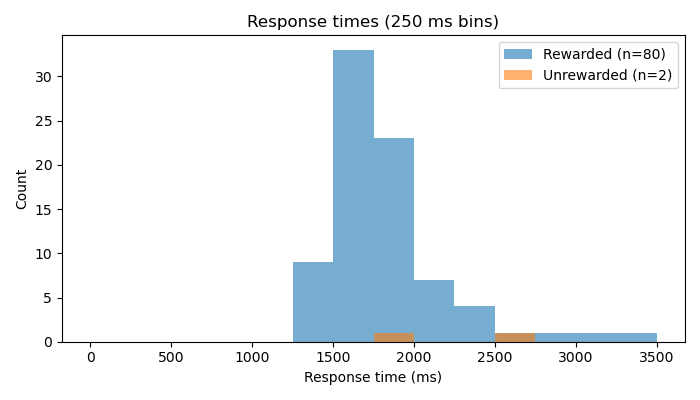

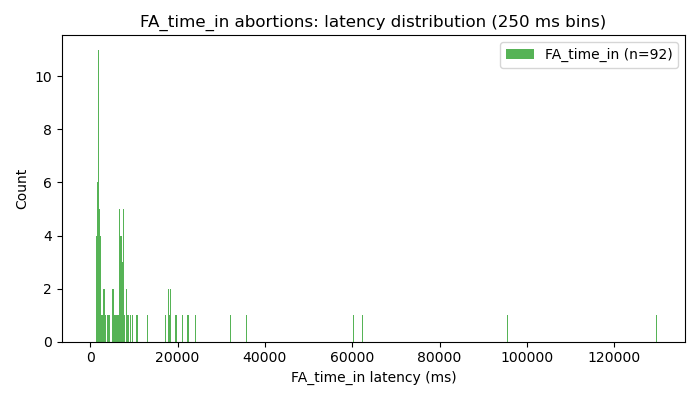

In [93]:
%matplotlib ipympl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rta = trial_outcomes_complete['response_time_analysis']
cls = trial_outcomes_complete['classification']
df_ab = cls.get('aborted_sequences_detailed', pd.DataFrame())

# Arrays from analyzer
rew = np.asarray(rta.get('rewarded_response_times', []), dtype=float)
unr = np.asarray(rta.get('unrewarded_response_times', []), dtype=float)

bin_ms = 250
max_ms_ru = max(rew.max() if rew.size else 0, unr.max() if unr.size else 0) or bin_ms
bins_ru = np.arange(0, math.ceil(max_ms_ru / bin_ms) * bin_ms + bin_ms, bin_ms)

plt.figure(figsize=(7,4))
plt.hist(rew, bins=bins_ru, alpha=0.6, label=f'Rewarded (n={len(rew)})', color='#1f77b4')
plt.hist(unr, bins=bins_ru, alpha=0.6, label=f'Unrewarded (n={len(unr)})', color='#ff7f0e')
plt.xlabel('Response time (ms)')
plt.ylabel('Count')
plt.title('Response times (250 ms bins)')
plt.legend()
plt.tight_layout()
plt.show()

# FA_time_in abortions (latency from abortion to first reward poke)
fa_in = np.array([], dtype=float)
if not df_ab.empty and 'fa_label' in df_ab and 'fa_latency_ms' in df_ab:
    fa_in = pd.to_numeric(
        df_ab.loc[df_ab['fa_label'] == 'FA_time_in', 'fa_latency_ms'],
        errors='coerce'
    ).dropna().astype(float).to_numpy()

max_ms_fa = fa_in.max() if fa_in.size else bin_ms
bins_fa = np.arange(0, math.ceil(max_ms_fa / bin_ms) * bin_ms + bin_ms, bin_ms)

plt.figure(figsize=(7,4))
plt.hist(fa_in, bins=bins_fa, alpha=0.8, color='#2ca02c', label=f'FA_time_in (n={len(fa_in)})')
plt.xlabel('FA_time_in latency (ms)')
plt.ylabel('Count')
plt.title('FA_time_in abortions: latency distribution (250 ms bins)')
plt.legend()
plt.tight_layout()
plt.show()

# Miscellaneous 

In [ ]:
cls = res['classification']
# Code like this can be used to extract data from res. This will display all trials with < threshold poke times in completed sequences
comp = cls["completed_sequences_with_response_times"]
pos_pokes_all = build_position_pokes_table(cls)
short_pokes = build_position_pokes_table(cls, threshold_ms=200)
display(short_pokes) 

In [21]:
# Find X s window with the most rewarded trials - used to find video segments

def find_peak_rewarded_window(res, window_sec=40):
    # Get rewarded trials table
    cls = res.get("classification", res)
    df = cls.get("completed_sequence_rewarded", pd.DataFrame())
    if df.empty:
        print("No rewarded trials found.")
        return None

    # Use valve_open_ts as trial time (or poke_first_in if you prefer)
    times = pd.to_datetime(df["sequence_start"], errors="coerce")
    df = df.assign(trial_time=times)
    df = df.dropna(subset=["trial_time"]).sort_values("trial_time").reset_index(drop=True)

    # Find the window with the most rewarded trials
    best_count = 0
    best_start = None
    best_end = None
    best_indices = []

    trial_times = df["trial_time"].values
    n = len(trial_times)
    for i in range(n):
        start = trial_times[i]
        end = start + np.timedelta64(window_sec, "s")
        # Find all trials within [start, end)
        mask = (trial_times >= start) & (trial_times < end)
        count = mask.sum()
        if count > best_count:
            best_count = count
            best_start = start
            best_end = end
            best_indices = np.where(mask)[0]

    print(f"Max rewarded trials in any {window_sec}s window: {best_count}")
    print(f"Window: {best_start} to {best_end}")
    # Optionally display the trials in that window
    display(df.iloc[best_indices])
    return df.iloc[best_indices]

# Example usage:
peak_trials = find_peak_rewarded_window(res, window_sec=40)

Max rewarded trials in any 40s window: 3
Window: 2025-09-08T13:56:21.521888000 to 2025-09-08T13:57:01.521888000


,initiation_sequence_time,sequence_start,sequence_end,continuous_poke_time_ms,trial_id,attempt_number,timestamp,odor_sequence,num_odors,last_odor,...,hit_hidden_rule,await_reward_time,first_supply_time,first_supply_port,first_supply_odor_identity,supply1_count,supply2_count,total_supply_count,run_id,trial_time
0,2025-09-08 13:56:20.396000,2025-09-08 13:56:21.521888,2025-09-08 13:56:29.252992,303.456,1,1,2025-09-08 13:56:21.521888,"[OdorE, OdorD, OdorC, OdorF, OdorB]",5,OdorB,...,False,2025-09-08 13:56:26.602976,2025-09-08 13:56:27.742496,2,B,0,1,1,1,2025-09-08 13:56:21.521888
1,2025-09-08 13:56:29.252992,2025-09-08 13:56:37.138528,2025-09-08 13:56:44.724992,447.904,2,1,2025-09-08 13:56:37.138528,"[OdorD, OdorC, OdorF, OdorG, OdorA]",5,OdorA,...,False,2025-09-08 13:56:41.945984,2025-09-08 13:56:43.218496,1,A,1,0,1,1,2025-09-08 13:56:37.138528
2,2025-09-08 13:56:44.724992,2025-09-08 13:56:53.244800,2025-09-08 13:57:01.756096,221.408,3,1,2025-09-08 13:56:53.244800,"[OdorE, OdorG, OdorD, OdorC, OdorA]",5,OdorA,...,False,2025-09-08 13:56:58.558976,2025-09-08 13:57:00.239488,1,A,1,0,1,1,2025-09-08 13:56:53.244800


In [67]:
# Cutting video segments around start and end times. E.g., used to get video around peak rewarded trials identified above. 
start_time = "13:56:19.0"
end_time = "13:56:50.0"
cut_video(26, 20250908, start_time, end_time)

Successfully read 1723 frames from /Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-121_date-20250908/behav/2025-09-08T12-55-53/VideoData/VideoData_1904-02-05T02-00-00.avi
MoviePy - Building video /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-121_date-20250908/video_analysis/video_cut_13-56-19-000000_13-56-50-000000.mp4.
MoviePy - Writing video /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-121_date-20250908/video_analysis/video_cut_13-56-19-000000_13-56-50-000000.mp4



MoviePy - Done !
MoviePy - video ready /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-121_date-20250908/video_analysis/video_cut_13-56-19-000000_13-56-50-000000.mp4
Saved cut video to: /Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-121_date-20250908/video_analysis/video_cut_13-56-19-000000_13-56-50-000000.mp4


PosixPath('/Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-121_date-20250908/video_analysis/video_cut_13-56-19-000000_13-56-50-000000.mp4')

# Testing of new functions

In [55]:
import pandas as pd

cls = trial_outcomes_complete['classification']
aborted = cls.get('aborted_sequences_detailed', pd.DataFrame())

if aborted is None or aborted.empty:
    print("No aborted_sequences_detailed available.")
else:
    # Get HR-aborted trial IDs from the classification
    hr_ab_df = None
    for k in ['aborted_sequences_HR', 'aborted_HR_sequences', 'aborted_hidden_rule_sequences']:
        if isinstance(cls.get(k), pd.DataFrame) and not cls[k].empty and 'trial_id' in cls[k]:
            hr_ab_df = cls[k]
            break

    if hr_ab_df is not None:
        hr_aborted_ids = set(hr_ab_df['trial_id'])
    else:
        # Fallback: if abortion_classification stored a boolean flag per trial
        if 'hit_hidden_rule' in aborted.columns:
            hr_aborted_ids = set(aborted.loc[aborted['hit_hidden_rule'] == True, 'trial_id'])
        else:
            hr_aborted_ids = set()  # no HR flag available

    if not hr_aborted_ids:
        print("No HR-aborted trial IDs available in classification (cannot reconcile counts).")
    else:
        # Filter to HR abortions at position 1
        hr_pos = int(cls.get('hidden_rule_position', 1))
        sub = aborted[(aborted['trial_id'].isin(hr_aborted_ids)) & (aborted['last_odor_position'] == 1)].copy()

        # Normalize FA labels and summarize
        def norm_fa(v):
            s = str(v).strip().lower()
            if s in ('fa_time_in','fa in','fa_in','in'): return 'FA_time_in'
            if s in ('fa_time_out','fa out','fa_out','out'): return 'FA_time_out'
            if s in ('fa_late','late'): return 'FA_late'
            return 'nFA'
        sub['fa_label'] = sub['fa_label'].apply(norm_fa)
        sub['fa_latency_ms'] = pd.to_numeric(sub['fa_latency_ms'], errors='coerce')

        total = len(sub)
        print(f"HR abortions at position 1: n={total}")
        counts = sub['fa_label'].value_counts().reindex(['nFA','FA_time_in','FA_time_out','FA_late'], fill_value=0)
        for k, v in counts.items():
            pct = (v/total*100.0) if total else 0.0
            print(f"  - {k}: {v} ({pct:.1f}%)")

        # List trials
        sub = sub.sort_values('abortion_time')
        for _, r in sub[['trial_id','abortion_time','fa_label','fa_latency_ms']].iterrows():
            print(f"  trial={r['trial_id']} | abort={pd.to_datetime(r['abortion_time']).isoformat()} | {r['fa_label']}"
                  f"{'' if pd.isna(r['fa_latency_ms']) else f' | lat={r['fa_latency_ms']:.1f} ms'}")

        display(sub[['trial_id','last_odor_position','abortion_type','fa_label','fa_latency_ms','abortion_time']].reset_index(drop=True))

HR abortions at position 1: n=4
  - nFA: 0 (0.0%)
  - FA_time_in: 3 (75.0%)
  - FA_time_out: 1 (25.0%)
  - FA_late: 0 (0.0%)
  trial=39 | abort=2025-09-07T14:47:16.143008 | FA_time_in | lat=1808.4 ms
  trial=139 | abort=2025-09-07T16:21:42.175936 | FA_time_in | lat=1613.4 ms
  trial=185 | abort=2025-09-07T17:29:42.404160 | FA_time_in | lat=1651.1 ms
  trial=190 | abort=2025-09-07T17:33:31.910560 | FA_time_out | lat=2206.4 ms


,trial_id,last_odor_position,abortion_type,fa_label,fa_latency_ms,abortion_time
0,39,1,reinitiation_abortion,FA_time_in,1808.384,2025-09-07 14:47:16.143008
1,139,1,reinitiation_abortion,FA_time_in,1613.440,2025-09-07 16:21:42.175936
2,185,1,reinitiation_abortion,FA_time_in,1651.136,2025-09-07 17:29:42.404160
3,190,1,reinitiation_abortion,FA_time_out,2206.400,2025-09-07 17:33:31.910560


In [ ]:

cls = trial_outcomes_complete['classification']

# Pick the HR-timeout table (singular vs plural alias)
df = cls.get('completed_sequence_HR_rewarded')
if (df is None or df.empty) and 'completed_sequences_HR_rewarded' in cls:
    df = cls['completed_sequences_HR_rewarded']

if df is None or df.empty or 'trial_id' not in df:
    print("No HR timeout trials found.")
else:
    df = df.copy()

    # Session start for relative seconds
    di = data.get('digital_input_data', {})
    streams = [di.get(k, pd.Series(dtype=bool)) for k in ('DIPort0','DIPort1','DIPort2')]
    try:
        session_start = min([s.index[0] for s in streams if hasattr(s, 'empty') and not s.empty])
    except Exception:
        session_start = None

    # Choose best available timestamp per trial
    cand_cols = ['response_window_end', 'sequence_end', 'trial_end', 'await_reward_time']
    for c in cand_cols:
        if c in df:
            df[c] = pd.to_datetime(df[c], errors='coerce')

    def pick_time(row):
        for c in cand_cols:
            v = row.get(c)
            if pd.notna(v):
                return v
        return pd.NaT

    df['event_time'] = df.apply(pick_time, axis=1)
    if session_start is not None:
        df['event_time_s'] = (df['event_time'] - session_start).dt.total_seconds()
    else:
        df['event_time_s'] = pd.NA

    df = df.sort_values('event_time')
    print(f"HR timeout trials: n={len(df)}")
    for _, r in df[['trial_id','event_time','event_time_s']].iterrows():
        ts = r['event_time']
        rel = r['event_time_s']
        print(f"  trial={r['trial_id']} at {ts.isoformat() if pd.notna(ts) else 'NaT'}"
              f"{'' if pd.isna(rel) else f' (t={rel:.3f}s)'}")

    # Optional table view
    display(df[['trial_id','event_time','event_time_s'] + [c for c in cand_cols if c in df]].reset_index(drop=True))

# Debugging Functions:



In [70]:
def check_data_availability(data, events, odor_map):
    """Quick check of all data streams for availability and content"""
    
    print("=" * 60)
    print("DATA AVAILABILITY CHECK")
    print("=" * 60)
    
    # Check main data streams
    print("\n📊 DATA STREAMS:")
    for key, value in data.items():
        if isinstance(value, pd.DataFrame):
            has_data = not value.empty
            print(f"  {key}: {'✅ HAS DATA' if has_data else '❌ EMPTY'} ({value.shape})")
            if has_data:
                print(f"    Columns: {value.columns.tolist()}")
                print(f"    Sample:\n{value.head(3).to_string(max_cols=5)}")
                print()
        elif isinstance(value, pd.Series):
            has_data = not value.empty
            print(f"  {key}: {'✅ HAS DATA' if has_data else '❌ EMPTY'} ({len(value)} items)")
            if has_data:
                print(f"    Sample: {value.head(3).tolist()}")
                print()
        else:
            print(f"  {key}: {type(value).__name__}")
    
    # Check event streams
    print("\n🎯 EVENT STREAMS:")
    for key, value in events.items():
        if isinstance(value, pd.DataFrame):
            has_data = not value.empty
            print(f"  {key}: {'✅ HAS DATA' if has_data else '❌ EMPTY'} ({value.shape})")
            if has_data:
                print(f"    Columns: {value.columns.tolist()}")
                print(f"    Sample:\n{value.head(3).to_string()}")
                print()
    
    # Check odor mapping
    print("\n🌸 ODOR MAPPING:")
    print(f"  odour_to_olfactometer_map: {odor_map['odour_to_olfactometer_map']}")
    print(f"  valve_to_odor: {odor_map['valve_to_odor']}")
    
    # Check digital input ports specifically
    print("\n🔌 DIGITAL INPUT PORTS:")
    if 'digital_input_data' in data and not data['digital_input_data'].empty:
        digital_data = data['digital_input_data']
        for col in digital_data.columns:
            port_data = digital_data[col]
            has_activity = port_data.sum() > 0  # Check if any True values
            print(f"  {col}: {'✅ ACTIVE' if has_activity else '❌ NO ACTIVITY'} ({port_data.sum()} events)")
            if has_activity:
                # Show first few ON events
                on_events = port_data[port_data == True].head(3)
                print(f"    First ON events: {on_events.index.tolist()}")
    
    # Check output ports (LED control)
    print("\n💡 OUTPUT PORTS:")
    for stream_name in ['output_set', 'output_clear']:
        if stream_name in data and not data[stream_name].empty:
            output_data = data[stream_name]
            print(f"  {stream_name}:")
            for col in output_data.columns:
                port_data = output_data[col]
                has_activity = port_data.sum() > 0
                print(f"    {col}: {'✅ ACTIVE' if has_activity else '❌ NO ACTIVITY'} ({port_data.sum()} events)")

# Run the check
check_data_availability(data, events, odor_map)

DATA AVAILABILITY CHECK

📊 DATA STREAMS:
  heartbeat: ✅ HAS DATA ((9961, 2))
    Columns: ['Time', 'TimestampSeconds']
    Sample:
                 Time  TimestampSeconds
0 1904-01-12 03:42:00            963720
1 1904-01-12 03:42:01            963721
2 1904-01-12 03:42:02            963722

  real_time_offset: timedelta
  timestamp_to_time: ✅ HAS DATA (9961 items)
    Sample: [Timestamp('1904-01-12 03:42:00'), Timestamp('1904-01-12 03:42:01'), Timestamp('1904-01-12 03:42:02')]

  interpolate_time: function
  digital_input_data: ✅ HAS DATA ((6870, 4))
    Columns: ['DIPort0', 'DIPort1', 'DIPort2', 'DI3']
    Sample:
                            DIPort0  DIPort1  DIPort2    DI3
Time                                                        
2025-08-15 14:52:39.792832    False    False     True  False
2025-08-15 14:52:39.861536    False    False    False  False
2025-08-15 14:52:53.775296    False    False     True  False

  output_set: ✅ HAS DATA ((805, 14))
    Columns: ['DOPort0', 'DOPort1'

In [48]:
# Quick code to look for brief purge events in between odors in completed trials

import pandas as pd
import numpy as np
import re
from bisect import bisect_left, bisect_right

def list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=50.0, verbose=True):
    """
    Find Purge events shorter than threshold_ms that occur between distinct odor presentations
    in completed trials. A Purge onset is counted if it lies within:
       [current_odor_end - onset_slack_ms, next_odor_start + onset_slack_ms]
    Returns a list of dicts (one per event) and prints a summary.
    """

    # --- Helpers to resolve Purge columns ---
    def _ci_get(d, key):
        if not isinstance(d, dict):
            return None
        lk = str(key).lower()
        for k, v in d.items():
            if str(k).lower() == lk:
                return v
        return None

    def _col_to_idx(col, row_len=None):
        if isinstance(col, (int, np.integer)):
            idx_num = int(col)
        else:
            m = re.search(r'(\d+)', str(col))
            if not m:
                return None
            idx_num = int(m.group(1))
        if row_len is None:
            return idx_num
        if 0 <= idx_num < row_len:
            return idx_num
        if 1 <= idx_num <= row_len:
            return idx_num - 1
        return None

    def _resolve_odor_name(odor_map, olf_id, idx, col=None):
        v2o = odor_map.get("valve_to_odor", {})
        if isinstance(v2o, dict):
            name = v2o.get((olf_id, idx))
            if name is None and col is not None:
                name = v2o.get(col)
            if name is None:
                name = v2o.get(idx)
            if isinstance(name, str):
                return name
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        if isinstance(grid, (list, tuple)) and len(grid) > olf_id and isinstance(grid[olf_id], (list, tuple)):
            row = grid[olf_id]
            if 0 <= idx < len(row):
                return row[idx]
        return None

    def _purge_columns(odor_map):
        cols = []
        olf_valves = odor_map["olfactometer_valves"]
        grid = odor_map.get("odour_to_olfactometer_map") or odor_map.get("odor_to_olfactometer_map")
        for olf_id, df in olf_valves.items():
            if df is None or getattr(df, "empty", True):
                continue
            row_len = len(grid[olf_id]) if isinstance(grid, (list, tuple)) and len(grid) > olf_id else None
            for col in df.columns:
                idx = _col_to_idx(col, row_len=row_len)
                if idx is None:
                    continue
                name = _resolve_odor_name(odor_map, olf_id, idx, col=col)
                if isinstance(name, str) and name.lower() == "purge":
                    cols.append((olf_id, idx, col))
        return cols

    def _purge_events(odor_map):
        """Return list of dicts: {start,end,duration_ms,olf_id,idx,col} across all purge columns."""
        evs = []
        for olf_id, idx, col in _purge_columns(odor_map):
            df = odor_map["olfactometer_valves"][olf_id]
            if df is None or getattr(df, "empty", True):
                continue
            s = df[col].astype(bool)
            rises = s & ~s.shift(1, fill_value=False)
            falls = ~s & s.shift(1, fill_value=False)
            starts = list(s.index[rises])
            ends = list(s.index[falls])
            i = j = 0
            while i < len(starts) and j < len(ends):
                if ends[j] <= starts[i]:
                    j += 1
                    continue
                dur_ms = (ends[j] - starts[i]).total_seconds() * 1000.0
                evs.append({
                    "start": starts[i],
                    "end": ends[j],
                    "duration_ms": dur_ms,
                    "olf_id": olf_id,
                    "idx": idx,
                    "col": col,
                })
                i += 1
                j += 1
        evs.sort(key=lambda e: e["start"])
        return evs

    # --- Build completed trials dataframe and inter-odor windows ---
    cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)
    completed_keys = [
        "completed_sequence_rewarded",
        "completed_sequence_unrewarded",
        "completed_sequence_reward_timeout",
    ]
    completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
    completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

    def _trial_id(row):
        for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
            if k in row and pd.notna(row[k]):
                return row[k]
        return row.name

    # Collect inter-odor windows per trial: [(trial_id, pos_i, pos_j, win_start, win_end)]
    windows = []
    for _, row in completed_df.iterrows():
        pov = row.get("position_valve_times")
        if not isinstance(pov, dict) or not pov:
            continue
        tid = _trial_id(row)
        # sort positions by position number
        positions = sorted([p for p in pov.keys() if isinstance(p, (int, np.integer))])
        # windows between consecutive positions
        for i in range(len(positions) - 1):
            p_i = positions[i]
            p_j = positions[i + 1]
            end_i = pov[p_i].get("valve_end")
            start_j = pov[p_j].get("valve_start")
            if pd.isna(end_i) or pd.isna(start_j) or end_i is None or start_j is None:
                continue
            if end_i >= start_j:
                # overlapping/invalid; skip
                continue
            win_start = end_i - pd.Timedelta(milliseconds=onset_slack_ms)
            win_end = start_j + pd.Timedelta(milliseconds=onset_slack_ms)
            windows.append((tid, p_i, p_j, win_start, win_end))

    # --- Scan purge events and match onsets within windows ---
    purge_events = _purge_events(odor_map)
    starts = [e["start"] for e in purge_events]

    matches = []
    for tid, p_i, p_j, ws, we in windows:
        lo = bisect_left(starts, ws)
        hi = bisect_right(starts, we)
        for k in range(lo, hi):
            e = purge_events[k]
            if e["duration_ms"] < threshold_ms:
                matches.append({
                    "trial_id": tid,
                    "from_pos": p_i,
                    "to_pos": p_j,
                    "start": e["start"],
                    "end": e["end"],
                    "duration_ms": e["duration_ms"],
                    "olf_id": e["olf_id"],
                    "col": e["col"],
                })

    # Summary/print
    if verbose:
        print(f"Short Purge events (< {threshold_ms} ms) between odors in completed trials "
              f"(onset slack ±{onset_slack_ms} ms): {len(matches)}")
        by_trial = {}
        for m in matches:
            by_trial.setdefault(m["trial_id"], 0)
            by_trial[m["trial_id"]] += 1
        if matches:
            for m in sorted(matches, key=lambda x: (x["trial_id"], x["start"])):
                print(f"- trial {m['trial_id']} pos {m['from_pos']}->{m['to_pos']}: "
                      f"{m['start'].isoformat()} -> {m['end'].isoformat()} "
                      f"({m['duration_ms']:.1f} ms)  olf {m['olf_id']} col '{m['col']}'")
            print("\nCounts by trial:")
            for tid in sorted(by_trial):
                print(f"  trial {tid}: {by_trial[tid]}")

    return matches

# Example usage:
matches = list_short_purge_between_odors(trial_outcomes_complete, odor_map, threshold_ms=200.0, onset_slack_ms=100.0, verbose=True)
len(matches)

Short Purge events (< 200.0 ms) between odors in completed trials (onset slack ±100.0 ms): 113
- trial 4 pos 3->4: 2025-09-07T14:36:46.469536 -> 2025-09-07T14:36:46.605504 (136.0 ms)  olf 1 col 'Valve3'
- trial 5 pos 4->5: 2025-09-07T14:37:06.771488 -> 2025-09-07T14:37:06.870496 (99.0 ms)  olf 1 col 'Valve3'
- trial 6 pos 2->3: 2025-09-07T14:37:21.450496 -> 2025-09-07T14:37:21.620480 (170.0 ms)  olf 1 col 'Valve3'
- trial 7 pos 2->3: 2025-09-07T14:38:24.026496 -> 2025-09-07T14:38:24.108480 (82.0 ms)  olf 1 col 'Valve3'
- trial 7 pos 3->4: 2025-09-07T14:38:24.811520 -> 2025-09-07T14:38:24.934496 (123.0 ms)  olf 1 col 'Valve3'
- trial 9 pos 1->2: 2025-09-07T14:38:55.848480 -> 2025-09-07T14:38:55.997504 (149.0 ms)  olf 1 col 'Valve3'
- trial 11 pos 2->3: 2025-09-07T14:39:29.279488 -> 2025-09-07T14:39:29.375488 (96.0 ms)  olf 1 col 'Valve3'
- trial 13 pos 1->2: 2025-09-07T14:39:59.003488 -> 2025-09-07T14:39:59.202496 (199.0 ms)  olf 1 col 'Valve3'
- trial 14 pos 3->4: 2025-09-07T14:40:23.7

113

In [ ]:
# For a schema file, check any poke that is < threshold (e.g. 200 ms), within completed sequences
import pandas as pd
import json, ast
from pathlib import Path
from collections.abc import Mapping

def _parse_obj(x):
    if isinstance(x, (dict, list, tuple)):
        return x
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return None
    if isinstance(x, str):
        s = x.strip()
        if not s:
            return None
        # Try JSON first, then Python literal
        try:
            return json.loads(s)
        except Exception:
            try:
                return ast.literal_eval(s)
            except Exception:
                return None
    return None

def _iter_pos_items(ppt):
    # Yield (position, info_dict) for dict/list
    if isinstance(ppt, Mapping):
        for k, v in ppt.items():
            if not isinstance(v, Mapping):
                try:
                    v = dict(v)
                except Exception:
                    continue
            pos = v.get("position")
            if pos is None:
                try:
                    pos = int(k)
                except Exception:
                    pos = k
            yield pos, v
    elif isinstance(ppt, (list, tuple)):
        for v in ppt:
            if isinstance(v, Mapping):
                yield v.get("position"), v

def _normalize_valves(pvt):
    # Normalize to dict: position -> valve dict
    out = {}
    if isinstance(pvt, Mapping):
        items = list(pvt.items())
    elif isinstance(pvt, (list, tuple)):
        items = [(v.get("position"), v) for v in pvt if isinstance(v, Mapping)]
    else:
        items = []
    for k, v in items:
        if not isinstance(v, Mapping):
            try:
                v = dict(v)
            except Exception:
                v = {}
        pos = v.get("position")
        if pos is None:
            try:
                pos = int(k)
            except Exception:
                pos = k
        out[pos] = v
    return out

def extract_short_pokes_from_saved(schema_path: str | Path, threshold_ms: float = 200.0) -> pd.DataFrame:
    schema_path = Path(schema_path)
    csv_path = schema_path.with_suffix("").with_suffix(".csv")  # replace .schema.json -> .csv
    if not csv_path.exists():
        # fallback: try sibling CSV with same stem
        csv_path = schema_path.parent / (schema_path.stem.replace(".schema", "") + ".csv")
    if not csv_path.exists():
        raise FileNotFoundError(f"CSV not found next to schema: {csv_path}")

    df = pd.read_csv(csv_path)

    # Identify column names for per-position fields
    poke_col = None
    valve_col = None
    for c in df.columns:
        lc = c.lower()
        if poke_col is None and "position" in lc and "poke" in lc:
            poke_col = c
        if valve_col is None and "position" in lc and "valve" in lc:
            valve_col = c
    if poke_col is None:
        raise KeyError("Could not find position_poke_times column in CSV")
    if valve_col is None:
        # some outputs may not store per-position valves; still proceed
        valve_col = None

    rows = []
    for _, row in df.iterrows():
        ppt = _parse_obj(row.get(poke_col))
        if ppt is None:
            continue
        pvt_raw = _parse_obj(row.get(valve_col)) if valve_col else None
        valve_map = _normalize_valves(pvt_raw) if pvt_raw is not None else {}

        run_id = row.get("run_id")
        trial_id = row.get("trial_id")

        for pos, info in _iter_pos_items(ppt):
            if not isinstance(info, Mapping):
                try:
                    info = dict(info)
                except Exception:
                    continue
            poke_ms = pd.to_numeric(info.get("poke_time_ms"), errors="coerce")
            if pd.isna(poke_ms) or poke_ms <= 0 or poke_ms >= threshold_ms:
                continue

            # normalize pos
            try:
                pos_norm = int(pos) if pos is not None else None
            except Exception:
                pos_norm = pos

            vt = valve_map.get(pos_norm, {})
            odor = info.get("odor_name") or (vt or {}).get("odor_name")
            first_in = info.get("poke_first_in")
            valve_open = (vt or {}).get("valve_open_ts")
            valve_close = (vt or {}).get("valve_close_ts")
            event_ts = first_in if first_in is not None else valve_open  # measurement start

            rows.append({
                "run_id": run_id,
                "trial_id": trial_id,
                "position": pos_norm,
                "odor": odor,
                "poke_ms": float(poke_ms),
                "event_ts": event_ts,
                "valve_open_ts": valve_open,
                "valve_close_ts": valve_close,
                "poke_first_in": first_in,
            })

    out = pd.DataFrame(rows)
    if not out.empty:
        out["event_ts"] = pd.to_datetime(out["event_ts"], errors="coerce")
        out = out.sort_values(["run_id","trial_id","position","event_ts"], kind="stable", na_position="last").reset_index(drop=True)
    return out

# Use your saved path
schema_path = "/Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-122_date-20250909/saved_analysis_results/completed_sequences_with_response_times.schema.json"
short_pokes = extract_short_pokes_from_saved(schema_path, threshold_ms=200.0)
display(short_pokes)
print(f"{len(short_pokes)} positions with poke_time_ms < 200 ms")

In [11]:
# Identify trial IDs for trials with poke time bewlow threshold 
threshold_ms = 200.0

# Get the classification DataFrames
cls = trial_outcomes_complete.get("classification", trial_outcomes_complete)

completed_keys = [
    "completed_sequence_rewarded",
    "completed_sequence_unrewarded",
    "completed_sequence_reward_timeout",
]
completed_dfs = [cls[k] for k in completed_keys if k in cls and isinstance(cls[k], pd.DataFrame)]
completed_df = pd.concat(completed_dfs, ignore_index=True) if completed_dfs else pd.DataFrame()

def _trial_id(row):
    for k in ["trial_id", "trial_index", "sequence_index", "Trial", "Sequence", "trial"]:
        if k in row and pd.notna(row[k]):
            return row[k]
    return row.name  # fallback

hits = []
for _, row in completed_df.iterrows():
    pos_pokes = row.get("position_poke_times")
    if not isinstance(pos_pokes, dict):
        continue
    tid = _trial_id(row)
    for pos, info in pos_pokes.items():
        if not isinstance(info, dict):
            continue
        ms = info.get("poke_time_ms")
        if ms is None:
            continue
        if ms < threshold_ms:
            odor = info.get("odor_name")
            hits.append((ms, tid, pos, odor))

# Print results sorted by poke time
if not hits:
    print(f"No completed-trial positions with poke_time_ms < {threshold_ms} ms found.")
else:
    hits.sort(key=lambda x: x[0])
    print(f"Trials with poke_time_ms < {threshold_ms} ms (n={len(hits)}):")
    for ms, tid, pos, odor in hits:
        print(f"- trial {tid}, position {pos}, {odor}: {ms:.1f} ms")

Trials with poke_time_ms < 200.0 ms (n=11):
- trial 163, position 1, OdorF: 56.8 ms
- trial 107, position 1, OdorG: 100.1 ms
- trial 153, position 2, OdorC: 117.1 ms
- trial 161, position 3, OdorC: 155.9 ms
- trial 51, position 2, OdorE: 171.5 ms
- trial 130, position 2, OdorG: 187.9 ms
- trial 178, position 3, OdorD: 194.8 ms
- trial 179, position 2, OdorF: 197.9 ms
- trial 168, position 1, OdorG: 199.0 ms
- trial 181, position 1, OdorD: 199.8 ms
- trial 11, position 2, OdorE: 199.9 ms


In [47]:
# Can be used to test if Hidden Rule Odor Identities can be detected from the Schema file. 
session_settings, schema_settings = detect_settings.detect_settings(root)
print("HR index inferred:", schema_settings.get("hiddenRuleIndexInferred"))
print("HR odors inferred:", schema_settings.get("hiddenRuleOdorsInferred"))

HR index inferred: 0
HR odors inferred: ['OdorA', 'OdorB']


# Space for backup versions

In [ ]:
def merge_classifications(run_classifications: list[dict], verbose: bool = True) -> dict:
    """
    Merge multiple per-run classification dicts into one session-level classification.
    - Adds run_id (1..N) to every row in all tables.
    - Concatenates ALL tables across runs; sorts by time where relevant.
    - Does NOT rewrite trial_id (avoids dropping rows in tables without trial_id).
    - Aggregates response_time_analysis lists.
    - Attaches per-run count sanity metadata.
    """

    if not run_classifications:
        raise ValueError("merge_classifications: no run classifications provided")

    # Discover all DataFrame keys across runs
    table_keys: set[str] = set()
    for c in run_classifications:
        for k, v in c.items():
            if isinstance(v, pd.DataFrame):
                table_keys.add(k)

    merged: dict = {}

    # Concatenate each table; add run_id
    for key in sorted(table_keys):
        parts = []
        for ridx, c in enumerate(run_classifications, start=1):
            df = c.get(key)
            if isinstance(df, pd.DataFrame) and not df.empty:
                df2 = df.copy()
                if 'run_id' not in df2.columns:
                    df2['run_id'] = ridx
                parts.append(df2)
        if parts:
            out = pd.concat(parts, axis=0, ignore_index=True, sort=False)
            if 'sequence_start' in out.columns:
                sort_cols = ['sequence_start']
                if 'run_id' in out.columns:
                    sort_cols.append('run_id')
                out = out.sort_values(sort_cols).reset_index(drop=True)
            merged[key] = out
        else:
            merged[key] = pd.DataFrame()


    def _align_child_to_parent(parent_key: str, child_key: str, keys=('run_id','trial_id'), child_cols: list[str] | None = None):
        parent = merged.get(parent_key, pd.DataFrame())
        child = merged.get(child_key, pd.DataFrame())
        if not isinstance(parent, pd.DataFrame) or parent.empty:
            return  # nothing to align
        # ensure keys present in parent
        keys = [k for k in keys if k in parent.columns]
        if not keys:
            return
        if not isinstance(child, pd.DataFrame) or child.empty:
            # synthesize child with NaN columns
            aligned = parent[keys].copy()
            if child_cols:
                for c in child_cols:
                    aligned[c] = np.nan
            # include sequence_start for stability if available
            if 'sequence_start' in parent.columns and 'sequence_start' not in aligned.columns:
                aligned.insert(0, 'sequence_start', parent['sequence_start'].values)
            merged[child_key] = aligned
            return
        # restrict child to keys + child_cols (or infer child_cols = all non-key columns)
        if child_cols is None:
            child_cols = [c for c in child.columns if c not in keys]
        right = child[keys + child_cols].drop_duplicates(subset=keys, keep='last')
        aligned = parent[keys].merge(right, on=keys, how='left')
        # keep stable sort if possible and include sequence_start if present
        if 'sequence_start' in parent.columns:
            if 'sequence_start' not in aligned.columns:
                aligned = parent[['sequence_start'] + keys].merge(aligned, on=keys, how='left')
            cols = ['sequence_start'] + [c for c in aligned.columns if c != 'sequence_start']
            aligned = aligned[cols]
        merged[child_key] = aligned

    # Align RT table to completed_sequences
    _align_child_to_parent(
        'completed_sequences',
        'completed_sequences_with_response_times',
        keys=('run_id','trial_id'),
        child_cols=['response_time_ms', 'response_time_category']
    )

    # Align aborted detailed table to aborted_sequences
    # Keep only keys from parent + detailed columns on child
    if isinstance(merged.get('aborted_sequences'), pd.DataFrame):
        child = merged.get('aborted_sequences_detailed', pd.DataFrame())
        child_cols = [c for c in getattr(child, 'columns', []) if c not in ('run_id','trial_id')]
        _align_child_to_parent(
            'aborted_sequences',
            'aborted_sequences_detailed',
            keys=('run_id','trial_id'),
            child_cols=child_cols if child_cols else [
                'odor_sequence','presentations','last_event_index',
                'position_valve_times','position_poke_times',
                'last_odor_position','last_odor_name',
                'last_odor_valve_duration_ms','last_odor_poke_time_ms',
                'abortion_type','abortion_time','fa_label','fa_time','fa_latency_ms'
            ]
        )

    # Carry session-level params from first run
    first = run_classifications[0]
    for p in ['sample_offset_time_ms', 'minimum_sampling_time_ms', 'response_time_window_sec', 'hidden_rule_position']:
        merged[p] = first.get(p)

    # Aggregate response_time_analysis lists
    rta = defaultdict(list)
    for c in run_classifications:
        ra = c.get('response_time_analysis') or {}
        for k in ['rewarded_response_times', 'unrewarded_response_times',
                  'timeout_delayed_response_times', 'timeout_response_delay_times',
                  'all_response_times']:
            vals = ra.get(k, [])
            if isinstance(vals, (list, tuple)):
                rta[k].extend(list(vals))
    merged['response_time_analysis'] = dict(rta)

    # Per-run count sanity meta
    runs_meta = []
    for ridx, c in enumerate(run_classifications, start=1):
        def n(df_key):
            df = c.get(df_key)
            return int(len(df)) if isinstance(df, pd.DataFrame) else 0
        runs_meta.append({
            'run_id': ridx,
            'counts': {
                'initiated_sequences': n('initiated_sequences'),
                'non_initiated_sequences': n('non_initiated_sequences'),
                'non_initiated_odor1_attempts': n('non_initiated_odor1_attempts'),
                'completed_sequences': n('completed_sequences'),
                'aborted_sequences': n('aborted_sequences'),
            }
        })
    merged['runs'] = runs_meta

    # Rebuild indices if available
    if 'build_classification_index' in globals():
        try:
            merged['index'] = build_classification_index(merged)
        except Exception:
            merged['index'] = {}

    if verbose:
        # Optional sanity prints
        try:
            total_non_ini = int(len(merged.get('non_initiated_sequences', [])))
            total_pos1 = int(len(merged.get('non_initiated_odor1_attempts', [])))
            total_initiated = int(len(merged.get('initiated_sequences', [])))
            sum_non_ini = sum(r['counts']['non_initiated_sequences'] for r in runs_meta)
            sum_pos1 = sum(r['counts']['non_initiated_odor1_attempts'] for r in runs_meta)
            sum_initiated = sum(r['counts']['initiated_sequences'] for r in runs_meta)
            if total_non_ini != sum_non_ini or total_pos1 != sum_pos1 or total_initiated != sum_initiated:
                print("[merge_classifications] WARNING: count mismatch after merge")
                print(f"  non_initiated_sequences: merged={total_non_ini} vs per-run sum={sum_non_ini}")
                print(f"  non_initiated_odor1_attempts: merged={total_pos1} vs per-run sum={sum_pos1}")
                print(f"  initiated_sequences: merged={total_initiated} vs per-run sum={sum_initiated}")
            # Assert RT rows cover all completed trials
            comp = merged.get('completed_sequences', pd.DataFrame())
            comp_rt = merged.get('completed_sequences_with_response_times', pd.DataFrame())
            if isinstance(comp, pd.DataFrame) and isinstance(comp_rt, pd.DataFrame):
                if len(comp_rt) != len(comp):
                    print(f"[merge_classifications] WARNING: RT alignment mismatch: comp_rt={len(comp_rt)} vs comp={len(comp)}")
        except Exception:
            pass

    return merged

def print_merged_session_summary(merged_classification: dict) -> None:
    """
    Print a verbose, single-session-like summary for merged (multi-run) results.
    Uses merged DataFrames and precomputed columns only (no raw events needed).
    """
    cls = merged_classification or {}

    # Params
    sample_offset_time_ms = cls.get("sample_offset_time_ms")
    minimum_sampling_time_ms = cls.get("minimum_sampling_time_ms")
    response_time_window_sec = cls.get("response_time_window_sec")
    hr_pos = cls.get("hidden_rule_position")
    hr_idx = (hr_pos - 1) if isinstance(hr_pos, (int, np.integer)) else None

    # Tables
    def get_df(key):
        df = cls.get(key)
        return df if isinstance(df, pd.DataFrame) else pd.DataFrame()

    ini = get_df("initiated_sequences")
    non_ini = get_df("non_initiated_sequences")
    non_ini_pos1 = get_df("non_initiated_odor1_attempts")

    comp = get_df("completed_sequences")
    comp_rt = get_df("completed_sequences_with_response_times")

    try:
        if isinstance(comp, pd.DataFrame) and not comp.empty:
            keys = [k for k in ['run_id','trial_id'] if k in comp.columns]
            if keys:
                rt_cols = [c for c in ['response_time_ms','response_time_category'] if c in comp_rt.columns]
                right = comp_rt[keys + rt_cols].drop_duplicates(subset=keys, keep='last') if not comp_rt.empty and rt_cols else pd.DataFrame(columns=keys+['response_time_ms','response_time_category'])
                comp_rt = comp.merge(right, on=keys, how='left')
    except Exception:
        pass

    comp_rew = get_df("completed_sequence_rewarded")
    comp_unr = get_df("completed_sequence_unrewarded")
    comp_tmo = get_df("completed_sequence_reward_timeout")

    comp_hr = get_df("completed_sequences_HR")
    comp_hr_missed = get_df("completed_sequences_HR_missed")
    ab = get_df("aborted_sequences")
    ab_hr = get_df("aborted_sequences_HR")
    ab_det = get_df("aborted_sequences_detailed")

    # Helpers
    def pct(n, d):
        return (n / d * 100.0) if d else 0.0

    def fmt_ms(v):
        try:
            return f"{float(v):.1f}"
        except Exception:
            return "n/a"

    # Header
    print("=" * 80)
    print("CLASSIFYING TRIAL OUTCOMES WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS")
    print("=" * 80)
    if sample_offset_time_ms is not None:
        print(f"Sample offset time: {fmt_ms(sample_offset_time_ms)} ms")
    if minimum_sampling_time_ms is not None:
        print(f"Minimum sampling time: {fmt_ms(minimum_sampling_time_ms)} ms")
    if response_time_window_sec is not None:
        print(f"Response time window: {float(response_time_window_sec):.0f} s")

    # Trials overview (counts from merged tables only)
    total_attempts = int(len(ini) + len(non_ini))
    print("\nTRIAL CLASSIFICATION RESULTS WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS:")
    print(f"Hidden Rule Location: Position {hr_pos if hr_pos is not None else 'None'} (index {hr_idx if hr_idx is not None else 'None'})\n")

    baseline_n = int(len(non_ini))                     # non_initiated_sequences == baseline only
    pos1_n = int(len(non_ini_pos1))                   # non_initiated_odor1_attempts
    non_ini_total = baseline_n + pos1_n
    total_attempts = int(len(ini)) + non_ini_total

    print("\nTRIAL CLASSIFICATION RESULTS WITH HIDDEN RULE AND VALVE/POKE TIME ANALYSIS:")
    print(f"Hidden Rule Location: Position {hr_pos if hr_pos is not None else 'None'} (index {hr_idx if hr_idx is not None else 'None'})\n")

    print(f"Total attempts: {total_attempts}")
    print(f"-- Non-initiated sequences (total): {non_ini_total} ({(non_ini_total/total_attempts*100.0 if total_attempts else 0):.1f}%)")
    print(f"    -- Position 1 attempts within trials {pos1_n} ({(pos1_n/non_ini_total*100.0 if non_ini_total else 0):.1f}%)")
    print(f"    -- Baseline non-initiated sequences {baseline_n} ({(baseline_n/non_ini_total*100.0 if non_ini_total else 0):.1f}%)")
    print(f"-- Initiated sequences (trials): {int(len(ini))} ({(len(ini)/total_attempts*100.0 if total_attempts else 0):.1f}%)\n")

    # Sanity check against per-run sums (now comparing to baseline+pos1)
    runs_meta = cls.get('runs', [])
    try:
        if runs_meta:
            sum_baseline = sum(r['counts'].get('non_initiated_sequences', 0) for r in runs_meta)
            sum_pos1 = sum(r['counts'].get('non_initiated_odor1_attempts', 0) for r in runs_meta)
            sum_non_ini_total = sum_baseline + sum_pos1
            sum_ini = sum(r['counts'].get('initiated_sequences', 0) for r in runs_meta)
            if (non_ini_total != sum_non_ini_total) or (baseline_n != sum_baseline) or (pos1_n != sum_pos1) or (len(ini) != sum_ini):
                print("\n[merge sanity] WARNING: merged counts differ from per-run sums")
                print(f"  non-initiated total: merged={non_ini_total} vs per-run sum={sum_non_ini_total} (baseline {baseline_n} vs {sum_baseline}, pos1 {pos1_n} vs {sum_pos1})")
                print(f"  initiated_sequences: merged={len(ini)} vs per-run sum={sum_ini}\n")
    except Exception:
        pass


    # Initiated breakdown
    comp_n = int(len(comp))
    ab_n = int(len(ab))
    print("INITIATED TRIALS BREAKDOWN:")
    print(f"-- Completed sequences: {comp_n} ({pct(comp_n, len(ini)): .1f}%)")
    print(f"   -- Hidden Rule trials (HR): {int(len(comp_hr))} ({pct(len(comp_hr), comp_n):.1f}%)")
    print(f"   -- Hidden Rule Missed (HR_missed): {int(len(comp_hr_missed))} ({pct(len(comp_hr_missed), comp_n):.1f}%)")
    print(f"-- Aborted sequences: {ab_n} ({pct(ab_n, len(ini)): .1f}%)")
    print(f"   -- Aborted Hidden Rule trials (HR): {int(len(ab_hr))} ({pct(len(ab_hr), ab_n):.1f}%)\n")

    # Completed-trial poke/valve time ranges (unchanged)
    def collect_pos_stats(df: pd.DataFrame):
        import math
        pos_poke = {i: [] for i in range(1, 6)}
        pos_valve = {i: [] for i in range(1, 6)}
        odor_poke = {}
        odor_valve = {}
        for _, r in df.iterrows():
            pps = r.get("position_poke_times") or {}
            vps = r.get("position_valve_times") or {}
            for pos in range(1, 6):
                if pos in pps:
                    v = pps[pos].get("poke_time_ms")
                    if v is not None and not (isinstance(v, float) and math.isnan(v)):
                        pos_poke[pos].append(float(v))
                    od = pps[pos].get("odor_name")
                    if od:
                        odor_poke.setdefault(od, []).append(float(v) if v is not None else np.nan)
                if pos in vps:
                    v = vps[pos].get("valve_duration_ms")
                    if v is not None and not (isinstance(v, float) and math.isnan(v)):
                        pos_valve[pos].append(float(v))
                    od = vps[pos].get("odor_name")
                    if od:
                        odor_valve.setdefault(od, []).append(float(v) if v is not None else np.nan)
        # Clean NaNs
        odor_poke = {k: [x for x in vals if not (isinstance(x, float) and np.isnan(x))] for k, vals in odor_poke.items()}
        odor_valve = {k: [x for x in vals if not (isinstance(x, float) and np.isnan(x))] for k, vals in odor_valve.items()}
        return pos_poke, pos_valve, odor_poke, odor_valve

    pos_poke, pos_valve, odor_poke, odor_valve = collect_pos_stats(comp)

    def print_range_block_pos(_title, dct):
        print("----------------------------------------")
        for pos in range(1, 6):
            vals = dct.get(pos, [])
            if not vals:
                continue
            a = np.asarray(vals, dtype=float)
            print(f"Position {pos}: {a.min():.1f} - {a.max():.1f}ms (avg: {a.mean():.1f}ms, n={a.size})")

    def print_range_block_odor(_title, dct):
        print("--------------------------------------------------")
        for od in sorted(dct.keys()):
            vals = dct[od]
            if not vals:
                continue
            a = np.asarray(vals, dtype=float)
            print(f"{od}: {a.min():.1f} - {a.max():.1f}ms (avg: {a.mean():.1f}ms, n={a.size})")

    print("POKE TIME RANGES BY POSITION:")
    print_range_block_pos("", pos_poke)
    print("\nVALVE TIME RANGES BY POSITION:")
    print_range_block_pos("", pos_valve)
    print("\nPOKE TIME RANGES BY ODOR (ALL POSITIONS):")
    print_range_block_odor("", odor_poke)
    print("\nVALVE TIME RANGES BY ODOR (ALL POSITIONS):")
    print_range_block_odor("", odor_valve)

    # Non-initiated: show baseline and pos1 (no trial_id subtraction)
    def _choose_poke_series(df: pd.DataFrame, prefer_cols: list[str]) -> pd.Series:
        if not isinstance(df, pd.DataFrame) or df.empty:
            return pd.Series([], dtype=float)
        for c in prefer_cols:
            if c in df.columns:
                return pd.to_numeric(df[c], errors="coerce").dropna()
        return pd.Series([], dtype=float)

    print("\nNON-INITIATED TRIALS POKE TIMES:")
    print("----------------------------------------")
    # Baseline (from non_initiated_sequences)
    base_vals = _choose_poke_series(non_ini, ["continuous_poke_time_ms", "poke_time_ms", "poke_time", "poke_ms"])
    if base_vals.empty:
        print(f"Baseline non-initiated: n={baseline_n} (no valid poke times)")
    else:
        print(f"Baseline non-initiated: n={baseline_n} avg={base_vals.mean():.1f} ms range={base_vals.min():.1f}-{base_vals.max():.1f} ms")

    # Pos1 attempts (from non_initiated_odor1_attempts)
    pos1_vals = _choose_poke_series(
        non_ini_pos1,
        ["pos1_poke_time_ms", "attempt_poke_time_ms", "poke_time_ms", "poke_time", "poke_ms"]
    )
    if pos1_vals.empty:
        print(f"Pos1 attempts: n={pos1_n} (no valid poke times)")
    else:
        print(f"Pos1 attempts: n={pos1_n} avg={pos1_vals.mean():.1f} ms range={pos1_vals.min():.1f}-{pos1_vals.max():.1f} ms")

    # ================= Response time analysis (unchanged) =================
    print("=" * 80)
    print("RESPONSE TIME ANALYSIS - ALL COMPLETED TRIALS")
    print("=" * 80)
    print(f"Total completed trials: {int(len(comp))}\n")

    total_rt_rows = int(len(comp_rt))
    failed = int((comp_rt.get("response_time_category").isna() if "response_time_category" in comp_rt else pd.Series([], dtype=bool)).sum()) if total_rt_rows else 0
    succeeded = total_rt_rows - failed
    print("RESPONSE TIME ANALYSIS RESULTS:")
    print(f"Total completed trials analyzed: {total_rt_rows}")
    print(f"Failed response time calculations: {failed}")
    print(f"Successful response time calculations: {succeeded}\n")

    def rt_block(df, label):
        s = pd.to_numeric(df.get("response_time_ms"), errors="coerce").dropna() if isinstance(df, pd.DataFrame) and not df.empty else pd.Series([], dtype=float)
        if s.empty:
            print(f"{label}:\n  No {label.lower()}")
            return
        print(f"{label}:")
        print(f"  Count: {int(len(s))}")
        print(f"  Range: {s.min():.1f} - {s.max():.1f}ms")
        print(f"  Average: {s.mean():.1f}ms")
        print(f"  Median: {s.median():.1f}ms\n")

    rew_rt = comp_rt[comp_rt.get("response_time_category") == "rewarded"] if not comp_rt.empty else comp_rt
    unr_rt = comp_rt[comp_rt.get("response_time_category") == "unrewarded"] if not comp_rt.empty else comp_rt
    tdel_rt = comp_rt[comp_rt.get("response_time_category") == "timeout_delayed"] if not comp_rt.empty else comp_rt

    rt_block(rew_rt, "REWARDED TRIALS")
    if not comp_hr.empty and not comp_rt.empty and 'trial_id' in comp_hr and 'trial_id' in comp_rt:
        hr_ids = set(comp_hr['trial_id'])
        hr_rew_rt = rew_rt[rew_rt['trial_id'].isin(hr_ids)] if not rew_rt.empty else pd.DataFrame()
        if hr_rew_rt.empty:
            print("HR REWARDED TRIALS (response times): none\n")
        else:
            rt_block(hr_rew_rt, "HR REWARDED TRIALS (response times)")
    else:
        print("HR REWARDED TRIALS (response times): none\n")

    rt_block(unr_rt, "UNREWARDED TRIALS")
    if tdel_rt.empty:
        print("TIMEOUT TRIALS WITH DELAYED RESPONSES:\n  No timeout trials with delayed responses\n")
    else:
        rt_block(tdel_rt, "TIMEOUT TRIALS WITH DELAYED RESPONSES")

    s_all = pd.to_numeric(comp_rt.get("response_time_ms"), errors="coerce").dropna() if not comp_rt.empty else pd.Series([], dtype=float)
    print("ALL TRIALS WITH RESPONSE TIMES:")
    if s_all.empty:
        print("  No trials with response times")
    else:
        print(f"  Count: {int(len(s_all))}")
        print(f"  Range: {s_all.min():.1f} - {s_all.max():.1f}ms")
        print(f"  Average: {s_all.mean():.1f}ms")
        print(f"  Median: {s_all.median():.1f}ms")


    # ================= Aborted trials summary =================
    if not ab_det.empty:
        print("=" * 80)
        print("ABORTED TRIALS CLASSIFICATION SUMMARY")
        print("=" * 80)
        total = int(len(ab_det))
        ini_c = int((ab_det["abortion_type"] == "initiation_abortion").sum())
        rei_c = int((ab_det["abortion_type"] == "reinitiation_abortion").sum())
        print(f"- Total Aborted Trials: {total}")
        print(f"  - Re-Initiation Abortions: {rei_c} ({pct(rei_c, total):.1f}%)")
        print(f"  - Initiation Abortions:    {ini_c} ({pct(ini_c, total):.1f}%)\n")

        # Normalize FA label and count
        def _norm_fa(val):
            if pd.isna(val):
                return 'nFA'
            s = str(val).strip().lower()
            if s in ('fa_time_in', 'fa in', 'fa_in', 'in'):
                return 'FA_time_in'
            if s in ('fa_time_out', 'fa out', 'fa_out', 'out'):
                return 'FA_time_out'
            if s in ('fa_late', 'late'):
                return 'FA_late'
            return 'nFA'
        ab_det = ab_det.copy()
        ab_det["fa_label"] = ab_det["fa_label"].apply(_norm_fa) if "fa_label" in ab_det.columns else 'nFA'

        fa_in = int((ab_det["fa_label"] == "FA_time_in").sum()) if "fa_label" in ab_det else 0
        fa_out = int((ab_det["fa_label"] == "FA_time_out").sum()) if "fa_label" in ab_det else 0
        fa_late = int((ab_det["fa_label"] == "FA_late").sum()) if "fa_label" in ab_det else 0
        fa_total = fa_in + fa_out + fa_late
        nfa = total - fa_total

        print("False Alarms:")
        print(f"  - non-FA Abortions: {nfa}")
        print(f"  - False Alarm abortions: {fa_total} ({pct(fa_total, total):.1f}%)")
        lower_rt = response_time_window_sec if response_time_window_sec is not None else None
        upper_rt = response_time_window_sec * 3 if response_time_window_sec is not None else None
        if fa_total > 0:
            print(f"      - FA Time In - Within Response Time Window ({float(response_time_window_sec) if response_time_window_sec is not None else 'n/a'} s):  {fa_in} ({pct(fa_in, fa_total):.1f}%)")
            s_in = pd.to_numeric(ab_det.loc[ab_det['fa_label'] == 'FA_time_in', 'fa_latency_ms'], errors='coerce').dropna() if 'fa_latency_ms' in ab_det.columns else pd.Series([], dtype=float)
            if len(s_in):
                print(f"          - Response Time: avg={s_in.mean():.1f} ms, range: {s_in.min():.1f} - {s_in.max():.1f} ms")
            print(f"      - FA Time Out - Up to 3x Response Time Window({int(lower_rt)}-{int(upper_rt)} s):  {fa_out} ({pct(fa_out, fa_total):.1f}%)")
            s_out = pd.to_numeric(ab_det.loc[ab_det['fa_label'] == 'FA_time_out', 'fa_latency_ms'], errors='coerce').dropna() if 'fa_latency_ms' in ab_det.columns else pd.Series([], dtype=float)
            if len(s_out):
                print(f"          - Response Time: avg={s_out.mean():.1f} ms, range: {s_out.min():.1f} - {s_out.max():.1f} ms")
            print(f"      - FA Late - After 3x Response Time up to next trial (>{int(upper_rt)} s):{fa_late} ({pct(fa_late, fa_total):.1f}%)")
            s_late = pd.to_numeric(ab_det.loc[ab_det['fa_label'] == 'FA_late', 'fa_latency_ms'], errors='coerce').dropna() if 'fa_latency_ms' in ab_det.columns else pd.Series([], dtype=float)
            if len(s_late):
                print(f"          - Response Time: avg={s_late.mean():.1f} ms, range: {s_late.min():.1f} - {s_late.max():.1f} ms")

            # Breakdown at HR position
            abortions_at_hr_pos = ab_det[ab_det['last_odor_position'] == hr_pos].copy() if hr_pos is not None and 'last_odor_position' in ab_det.columns else pd.DataFrame()
            # Determine in-HR aborted IDs if table exists
            hr_aborted_ids = set(ab_hr['trial_id']) if not ab_hr.empty and 'trial_id' in ab_hr.columns else set()
            in_hr_trials = abortions_at_hr_pos[abortions_at_hr_pos['trial_id'].isin(hr_aborted_ids)].copy() if not abortions_at_hr_pos.empty else pd.DataFrame()
            non_hr_trials = abortions_at_hr_pos[~abortions_at_hr_pos['trial_id'].isin(hr_aborted_ids)].copy() if not abortions_at_hr_pos.empty else pd.DataFrame()

            def _print_fa_counts(df, indent="    "):
                if df is None or df.empty:
                    print(f"{indent}n=0")
                    return
                order = ['nFA', 'FA_time_in', 'FA_time_out', 'FA_late']
                cnt = df['fa_label'].value_counts().reindex(order, fill_value=0)
                total = int(len(df))
                for lbl in order:
                    v = int(cnt.get(lbl, 0))
                    p = pct(v, total)
                    print(f"{indent}{lbl}: {v} ({p:.1f}%)")

            total_at_hr = int(len(abortions_at_hr_pos))
            print(f"\n  Abortions at Hidden Rule Position {hr_pos if hr_pos is not None else 'n/a'}: n={total_at_hr}")
            if not abortions_at_hr_pos.empty:
                print(f"    Of which in Hidden Rule Trials: n={int(len(in_hr_trials))}")
                if not in_hr_trials.empty:
                    _print_fa_counts(in_hr_trials, indent="        ")
                print(f"    Non-Hidden Rule Abortions at HR Location: n={int(len(non_hr_trials))}")
                if not non_hr_trials.empty:
                    _print_fa_counts(non_hr_trials, indent="        ")

        # Non-last odor pokes section (if 'presentations' exists)
        if 'presentations' in ab_det.columns and 'last_event_index' in ab_det.columns and not ab_det.empty:
            pres_df = ab_det[['trial_id', 'presentations', 'last_event_index']].explode('presentations')
            pres_df = pres_df.dropna(subset=['presentations']).copy()
            if not pres_df.empty:
                pres = pd.concat([pres_df.drop(columns=['presentations']), pres_df['presentations'].apply(pd.Series)], axis=1)
                pres['is_last'] = pres['index_in_trial'] == pres['last_event_index']
                pres = pres[~pres['is_last']].copy()
                pres['poke_time_ms'] = pd.to_numeric(pres['poke_time_ms'], errors='coerce')
                pres_valid = pres.dropna(subset=['poke_time_ms']).copy()
                def stats_line(series, label):
                    s = pd.to_numeric(series, errors='coerce').dropna()
                    if s.empty:
                        print(f"{label}: n=0")
                    else:
                        print(f"{label}: n={len(s)} | avg={s.mean():.1f} ms | range={s.min():.1f}-{s.max():.1f} ms")
                print("\nPoke times (Excluding Abortion Odor/Position):")
                stats_line(pres_valid['poke_time_ms'], "  - All Odors Excluding Aborted Odor")
                if 'position' in pres_valid.columns:
                    for pos, grp in pres_valid.groupby('position'):
                        stats_line(grp['poke_time_ms'], f"  - Position {int(pos)}")
                if 'odor_name' in pres_valid.columns:
                    for odor, grp in pres_valid.groupby('odor_name'):
                        stats_line(grp['poke_time_ms'], f"  - Odor {odor}")

        # Last-odor poke stats
        def stats_line(series, label):
            s = pd.to_numeric(series, errors='coerce').dropna()
            if s.empty:
                print(f"{label}: n=0")
            else:
                print(f"{label}: n={len(s)} | avg={s.mean():.1f} ms | range={s.min():.1f}-{s.max():.1f} ms")
        print("\nLast Odor Poke Times:")
        stats_line(ab_det.loc[ab_det['abortion_type'] == 'reinitiation_abortion', 'last_odor_poke_time_ms'], "  - Re-Initiation Abortions")
        stats_line(ab_det.loc[ab_det['abortion_type'] == 'initiation_abortion', 'last_odor_poke_time_ms'], "  - Initiation Abortions")

        # Counts by last odor
        print("\nCounts by last odor:")
        if 'last_odor_name' in ab_det.columns:
            by = (ab_det.groupby(['last_odor_name', 'abortion_type']).size().unstack(fill_value=0))
            totals = ab_det.groupby('last_odor_name').size()
            for odor in totals.index:
                rei_v = int(by.loc[odor].get('reinitiation_abortion', 0))
                ini_v = int(by.loc[odor].get('initiation_abortion', 0))
                tot = int(totals.loc[odor])
                print(f"  - {odor}: {tot} abortions, Re-initiation {rei_v}, Initiation {ini_v}")

        # Counts by last position
        print("\nCounts by last position:")
        if 'last_odor_position' in ab_det.columns:
            by = (ab_det.groupby(['last_odor_position', 'abortion_type']).size().unstack(fill_value=0))
            totals = ab_det.groupby('last_odor_position').size()
            for pos in sorted(totals.index):
                rei_v = int(by.loc[pos].get('reinitiation_abortion', 0))
                ini_v = int(by.loc[pos].get('initiation_abortion', 0))
                tot = int(totals.loc[pos])
                print(f"  - Position {int(pos)}: {tot} abortions, Re-initiation {rei_v}, Initiation {ini_v}")


In [ ]:
# Backup for video cutting, but use cut_video() function instead. 
from pathlib import Path
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

video_dir = Path("/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-121_date-20250908/behav/2025-09-08T12-55-53/VideoData")
session_root = video_dir.parent
from utils import load_all_streams

streams = load_all_streams(session_root, verbose=False)
video_meta = streams['video_data']

print("video_meta columns:", video_meta.columns)
start_dt = pd.to_datetime("2025-09-08 13:56:19.00000")
end_dt = pd.to_datetime("2025-09-08 13:56:50.00000")
frames_in_window = video_meta[(video_meta.index >= start_dt) & (video_meta.index <= end_dt)]
print(f"Found {len(frames_in_window)} frames in window.")

if frames_in_window.empty:
    print("No frames found in the requested time window.")
else:
    # Auto-detect frame column
    frame_col = [c for c in frames_in_window.columns if 'frame' in c.lower()][0]
    frame_indices = frames_in_window[frame_col].tolist()
    print(f"Using frame column: {frame_col}")

    # Try each video file until frames can be read
    avi_files = sorted(video_dir.glob("*.avi"))
    for video_file in avi_files:
        print(f"Trying video file: {video_file}")
        cap = cv2.VideoCapture(str(video_file))
        images = []
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                images.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            else:
                print(f"Warning: could not read frame {idx} from {video_file}")
        cap.release()
        if images:
            print(f"Successfully read {len(images)} frames from {video_file}")
            # Save as MP4
            out_dir = Path("/Volumes/harris/hypnose/derivatives/sub-026_id-077/ses-121_date-20250908/video_analysis")
            out_dir.mkdir(parents=True, exist_ok=True)
            out_mp4 = out_dir / f"video_cut_{start_dt.strftime('%H-%M-%S-%f')}_{end_dt.strftime('%H-%M-%S-%f')}.mp4"
            clip = ImageSequenceClip(images, fps=30)
            clip.write_videofile(str(out_mp4), codec="libx264", audio=False)
            print(f"Saved cut video to: {out_mp4}")
            break  # Stop after first successful extraction
        else:
            print(f"No frames extracted from {video_file}, trying next file.")